In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [ ]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

In [76]:
basepath = r"Z:\Data\HMC1\day13"
ar = assembly_reactivation.AssemblyReact(basepath, brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
        putativeCellType="Pyr")
ar.load_data()
ar.restrict_epochs_to_pre_task_post()

ar.get_weights([ar.ripples.expand(0.2)])

In [14]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(ar.patterns)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [25]:
patterns.shape, is_member_sig.shape, np.array(keep_assembly).shape, is_member.shape

((18, 319), (18, 319), (55,), (55, 319))

In [70]:
assembly_df = pd.DataFrame()
assembly_df["patterns"] = patterns.ravel()
assembly_df["is_member_sig"] = is_member_sig.ravel()
assembly_df["assembly_n"] = (np.ones_like(patterns).T * np.arange(patterns.shape[0])).T.astype(int).ravel()
assembly_df["UID"] = np.tile(ar.cell_metrics.UID.values, patterns.shape[0])
assembly_df["putativeCellType"] = np.tile(ar.cell_metrics.putativeCellType.values, patterns.shape[0])
assembly_df["brainRegion"] = np.tile(ar.cell_metrics.brainRegion.values, patterns.shape[0])
assembly_df["deepSuperficial"] = np.tile(ar.cell_metrics.deepSuperficial.values, patterns.shape[0])
assembly_df["deepSuperficialDistance"] = np.tile(ar.cell_metrics.deepSuperficialDistance.values, patterns.shape[0])

assembly_df

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
0,-0.034116,False,0,1,Pyramidal Cell,PFC,Cortical,NaN
1,0.015217,False,0,2,Pyramidal Cell,PFC,Cortical,NaN
2,-0.024124,False,0,3,Pyramidal Cell,PFC,Cortical,NaN
3,-0.047657,False,0,4,Pyramidal Cell,PFC,Cortical,NaN
4,-0.039098,False,0,6,Pyramidal Cell,PFC,Cortical,NaN
...,...,...,...,...,...,...,...,...
5737,0.015188,False,17,540,Pyramidal Cell,MEC,Cortical,NaN
5738,0.023366,False,17,541,Pyramidal Cell,MEC,Cortical,NaN
5739,0.009918,False,17,542,Pyramidal Cell,MEC,Cortical,NaN
5740,-0.046966,False,17,546,Pyramidal Cell,MEC,Cortical,NaN


In [77]:
deep_mec = []
deep_pfc = []
superficial_mec = []
superficial_pfc = []

for n in assembly_df.assembly_n.unique():
    temp_assembly_df = assembly_df[(assembly_df.assembly_n == n) & (assembly_df.is_member_sig)]
    deep_mec.append(sum(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC") | (temp_assembly_df.deepSuperficial == "Deep")))
    deep_pfc.append(sum(temp_assembly_df.brainRegion.str.contains("PFC") | (temp_assembly_df.deepSuperficial == "Deep")))
    superficial_mec.append(sum(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC") | (temp_assembly_df.deepSuperficial == "Superficial")))
    superficial_pfc.append(sum(temp_assembly_df.brainRegion.str.contains("PFC") | (temp_assembly_df.deepSuperficial == "Superficial")))


Text(0.5, 1.0, 'Number of cells in each assembly')

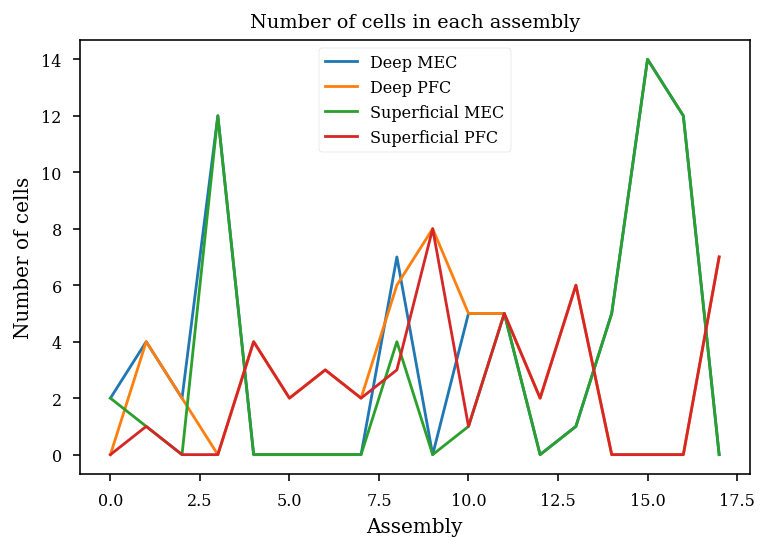

In [78]:
plt.plot(deep_mec)
plt.plot(deep_pfc)
plt.plot(superficial_mec)
plt.plot(superficial_pfc)
plt.legend(["Deep MEC", "Deep PFC", "Superficial MEC", "Superficial PFC"])
plt.xlabel("Assembly")
plt.ylabel("Number of cells")
plt.title("Number of cells in each assembly")


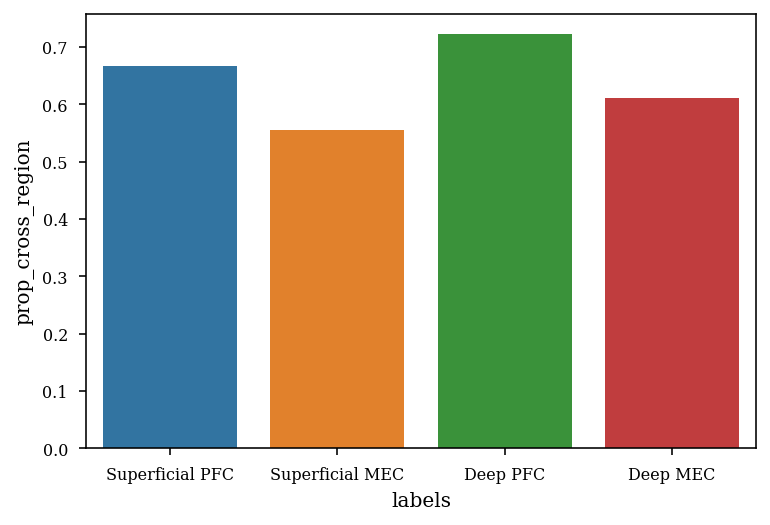

In [88]:
temp_df = pd.DataFrame()

temp_df["prop_cross_region"] = [
    np.mean(np.array(superficial_pfc) > 0),
    np.mean(np.array(superficial_mec) > 0),
    np.mean(np.array(deep_pfc) > 0),
    np.mean(np.array(deep_mec) > 0),
]
temp_df["labels"] = ["Superficial PFC", "Superficial MEC", "Deep PFC", "Deep MEC"]

ax = sns.barplot(x="labels", y="prop_cross_region", data=temp_df)

In [27]:
def lighten_color(color, amount=0.5):
    """
    Lightens a color by a certain percentage.
    This is useful for adjusting colors for a particular element of a page.
    :param color: The hex color code, e.g. #AABBCC
    :param amount: The amount to lighten the color by.
    :return: The lightened color code in hex, e.g. #FFFFFF
    """
    try:
        c = color.lstrip('#')
        c = tuple(int(c[i:i + 2], 16) for i in (0, 2, 4))
        c = (
            int((1 - amount) * c[0] + amount * 255),
            int((1 - amount) * c[1] + amount * 255),
            int((1 - amount) * c[2] + amount * 255),
        )
        return '#%02x%02x%02x' % c
    except ValueError:
        return color

In [28]:
group_colors = {
    "CA1": "#615766",
    "MEC": "#de2020",
    "PFC": "#116f70",
}

colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
for reg in group_colors.keys():
    idx = ar.cell_metrics.brainRegion.str.contains(reg).values
    colors[:,idx] = [group_colors[reg]] * sum(idx)

for i in range(is_member_sig.shape[0]): 
    for j in range(is_member_sig.shape[1]):
        if is_member_sig[i,j] != 1:
            colors[i,j] = lighten_color(colors[i,j],0.5)


[Text(-0.5, 0, '-0.5'), Text(0.5, 0, '0.5')]

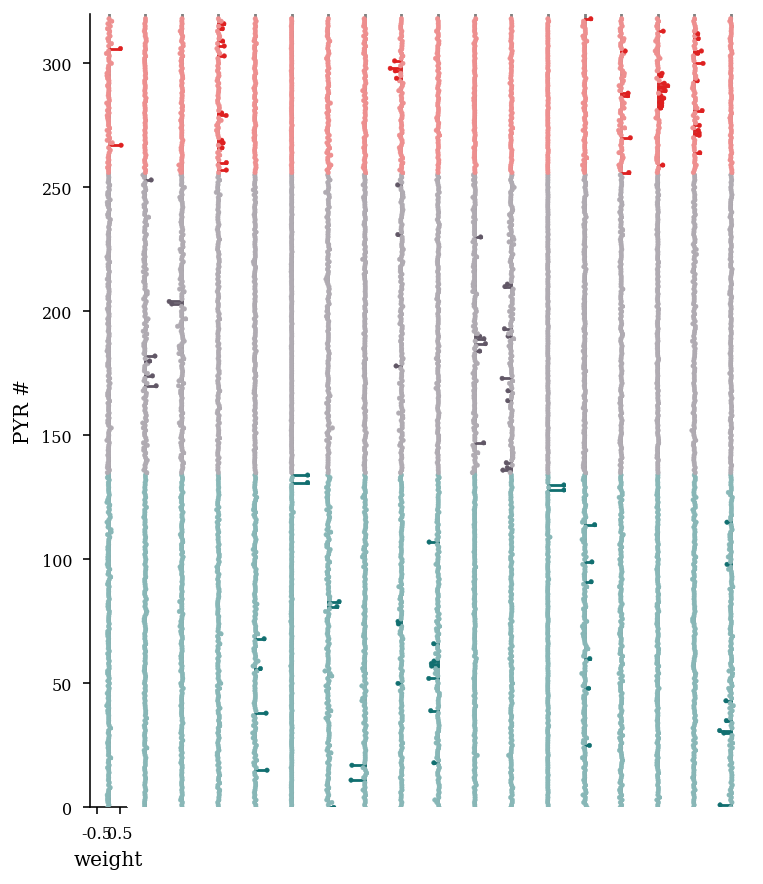

In [29]:
# patterns.shape
# colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
# lighten_color("#615766",.9)
# colors[is_member_sig] = "#615766"

fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=1, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=5)

    # axs[i].scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

for i in range(patterns.shape[0]):
    axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].set_ylim(0,patterns.shape[1]+1)

for i in range(patterns.shape[0]):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)  

for i in np.arange(1,patterns.shape[0]):
    axs[i].spines["left"].set_visible(False)  
    axs[i].spines["bottom"].set_visible(False)      
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])

axs[0].set_ylabel('PYR #')
axs[0].set_xlabel('weight')
axs[0].set_xticks([-.5,.5])
axs[0].set_xticklabels([-.5,.5])
    

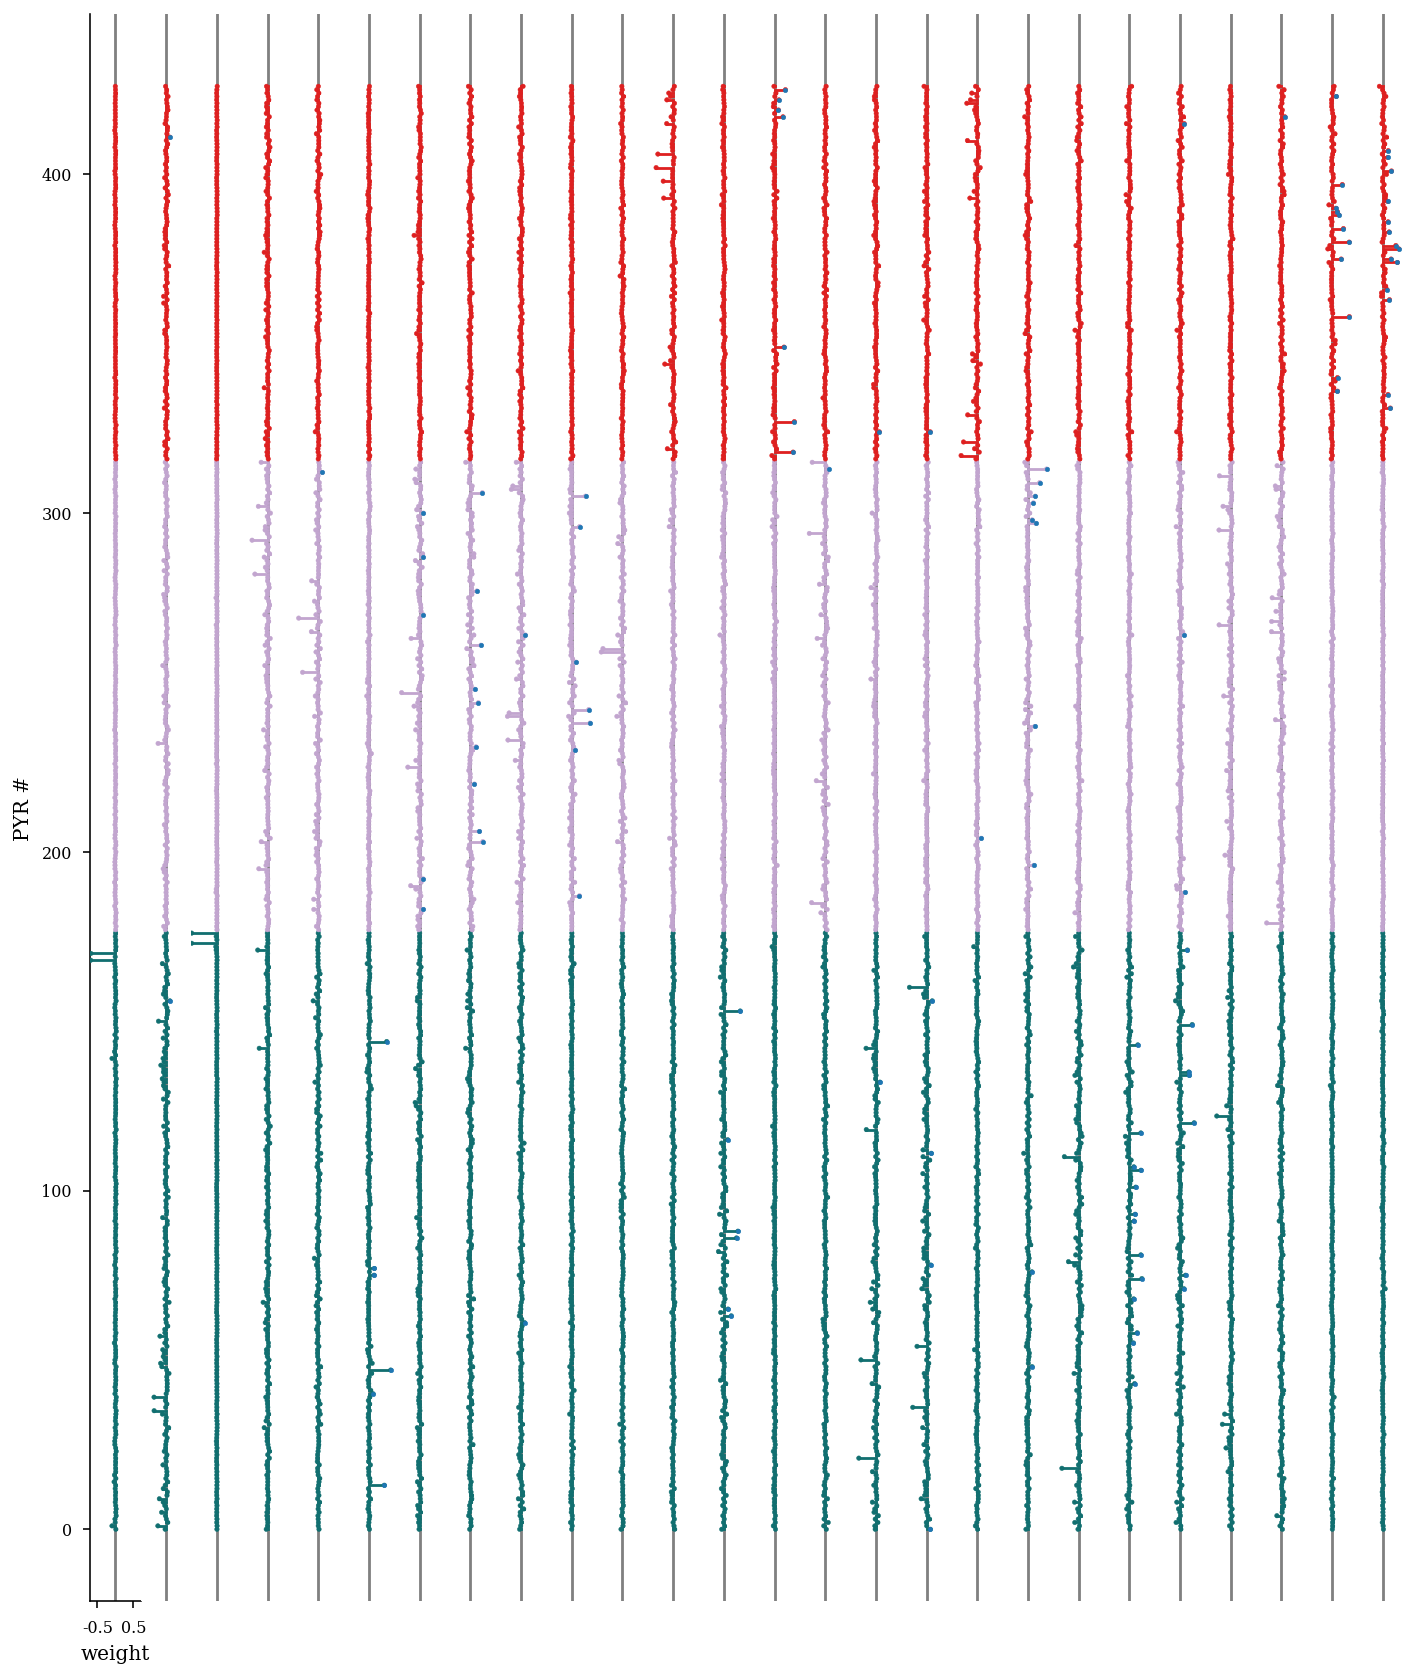

In [31]:
fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=2, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors,zorder=1000,s=5)

    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(assmbl[idx],np.arange(len(assmbl))[idx],zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[j],zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item,0]),[j,j],color=colors_sig[j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)  

    for i in np.arange(1,patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)  
        axs[i].spines["bottom"].set_visible(False)      
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel('PYR #')
    axs[0].set_xlabel('weight')
    axs[0].set_xticks([-.5,.5])
    axs[0].set_xticklabels([-.5,.5])


<StemContainer object of 3 artists>

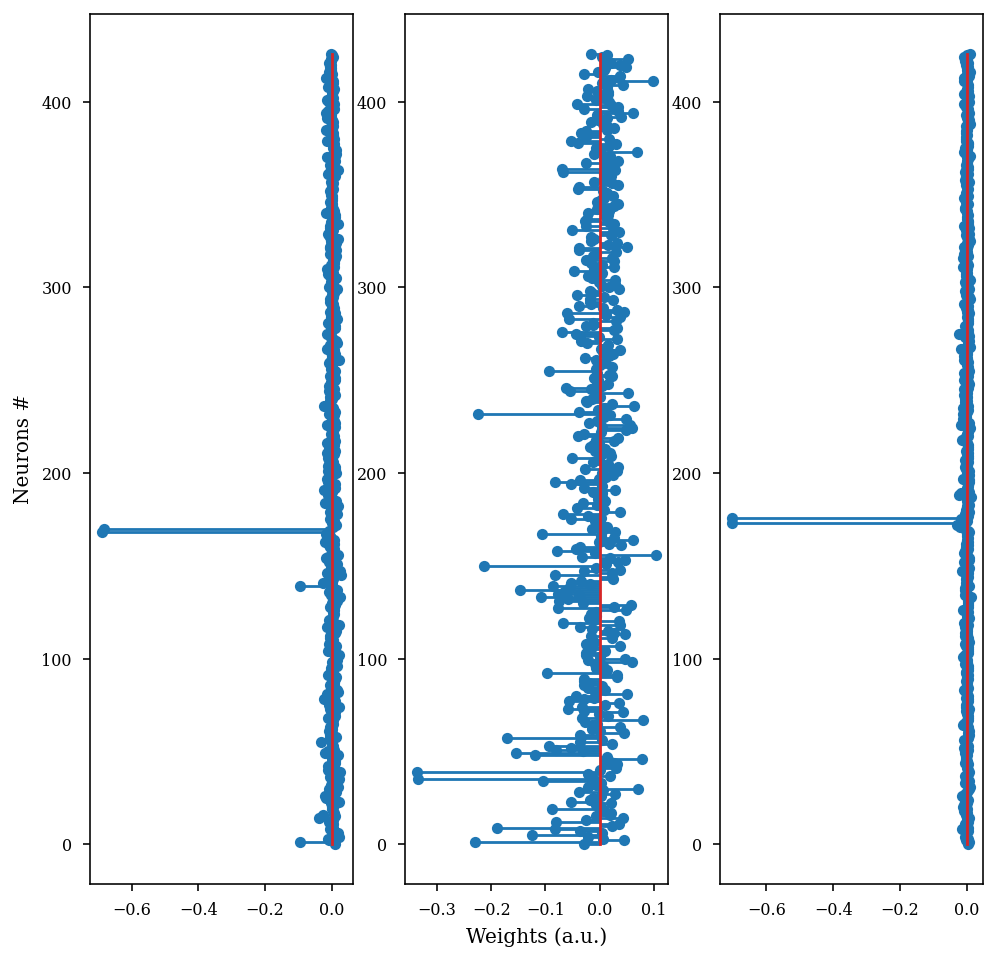

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
ax1 = plt.subplot(131)
plt.stem(patterns[0,:], orientation = 'horizontal')
ax1.set_ylabel('Neurons #')

ax2 = plt.subplot(132, sharey=ax1)
plt.stem(patterns[1,:], orientation = 'horizontal')
ax2.set_xlabel('Weights (a.u.)')

ax3 = plt.subplot(133, sharey=ax1)
plt.stem(patterns[2,:], orientation = 'horizontal')